This notebook will walk through all the specs in the paper. In addition, we will use specification gradients to tweak random sampled trajectories, and show such tweaking can generate trajectories which satisfy all the specs. 

The implementation of these specs and the LTL parser is in `src/schrl/tltl/`. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th

from schrl.tltl.template import sequence, coverage, branch, loop, signal


The tweaking function is the `grad_tweak` below. We optimize a trajectory to maximize the quantitative value evaluated by a spec. 

In [2]:
def grad_tweak(spec, path, steps=2000, lr=1e-1):
    print(f"initial score (< 0): {spec(path)}")
    seq_path_opt = th.optim.Adam(params=[path], lr=lr)

    for _ in range(steps):
        loss = -spec(path)
        seq_path_opt.zero_grad()
        loss.backward()
        seq_path_opt.step()

    print(f"final score (> 0): {spec(path)}")


## Sequence

The sequence spec asks a trajectory to visit the given goals by order. Additionally, we need to specify the time visiting these goals. It can be written as 
$$
    \bigwedge_{i=0}^{N} \Diamond_{[t_{i}, t_{i+1} - 1]} \phi_{i},
$$
where $t_i < t_{i+1}$ and $\phi_i$ is a goal spec. This formula means that eventually reaching all the goals in specified order.

In [3]:
seq_goals = np.array([
    [0.5, 0.75], [1.5, 1], [-2, 2], [0, 0]
])
seq_time = [
    [1, 2], [2, 3], [3, 4], [4, 5]
]
seq_spec = sequence(seq_goals, seq_time)
seq_spec


((E [1, 2)goal-0 & E [2, 3)goal-1) & E [3, 4)goal-2) & E [4, 5)goal-3

LTL operators are magenta; the time slot of a spec is colored as yellow, and the predicates are with blue. 

Below, we randomly sample a trajectory and optimize it. 

initial score (< 0): -2.471616268157959
final score (> 0): 0.28837698698043823


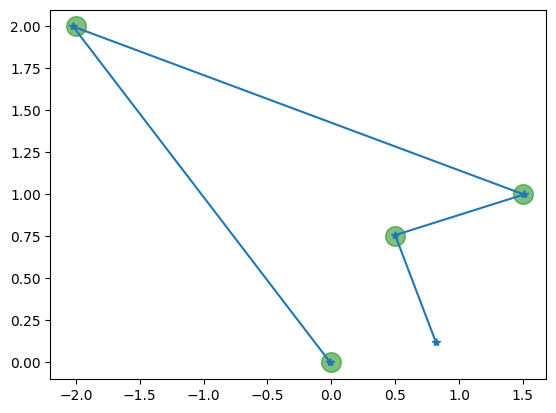

In [4]:
seq_path = th.rand((5, 2), requires_grad=True)
grad_tweak(seq_spec, seq_path)
seq_path_np = seq_path.detach().numpy()
plt.scatter(seq_goals[:, 0], seq_goals[:, 1], s=200, color="g", alpha=0.5)
_ = plt.plot(seq_path_np[:, 0], seq_path_np[:, 1], "*-")


The optimized trajectory visited [0.5, 0.75], [1.5, 1], [-2, 2], [0, 0] in order.

## Coverage

The coverage task requires a trajectory visit all the given spec with random order. Its formula is
$$
    \bigwedge_{i=0}^N \Diamond_{[1, T]} \phi_i.
$$

In [5]:
cover_goals = np.array([
    [0.5, 0.75], [1.5, 1], [-2, 2], [0, 0]
])
cover_spec = coverage(cover_goals)
cover_spec


((E [0, None)goal-0 & E [0, None)goal-1) & E [0, None)goal-2) & E [0, None)goal-3

We choose the same goals as the sequence task. 

initial score (< 0): -2.0683748722076416
final score (> 0): 0.29181969165802


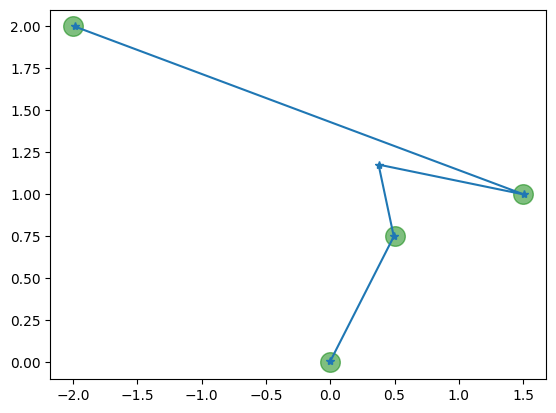

In [6]:
cover_path = th.rand((5, 2), requires_grad=True)
grad_tweak(cover_spec, cover_path)
cover_path_np = cover_path.detach().numpy()
plt.scatter(cover_goals[:, 0], cover_goals[:, 1], s=200, color="g", alpha=0.5)
_ = plt.plot(cover_path_np[:, 0], cover_path_np[:, 1], "*-")


The optimized trajectory visited all the [0.5, 0.75], [1.5, 1], [-2, 2], [0, 0], but ignored the order.

## Branch

Branch task can be seen as a collection of $if \dots then \dots$ clusters, e.g., if visiting $A$ then visiting $B$, if visiting $C$ then visiting $D$. We encode this type of task as
$$
    \bigvee_{i=0}^\frac{N}{2} \left( \Diamond_{[1, T]} \phi_i  \land \square_{[1, T]} \left(\phi_i \implies \Diamond_{[t, T]} \phi_{2i} \right) \right),
$$
where $N$ is even. This formula says that eventually satisfying $\phi_i$, and globally $\phi_i$ implies that $\phi_{2i}$ will be satisfied eventually. The $\phi_i$ and  $\phi_{2i}$ has the same color

In [7]:
branches = np.array([
    [[1, 1], [0.5, 0.4]],
    [[-1, -1], [-0.5, -0.4]]
])
branch_spec = branch(branches)
branch_spec

(((traj[1]<<[1. 1.]>> -> E [1, None)goal-0) & traj[1]<<[1. 1.]>>) & E [1, None)goal-0) | (((traj[1]<<[-1. -1.]>> -> E [1, None)goal-1) & traj[1]<<[-1. -1.]>>) & E [1, None)goal-1)

initial score (< 0): -0.38928595185279846
final score (> 0): 0.24497775733470917


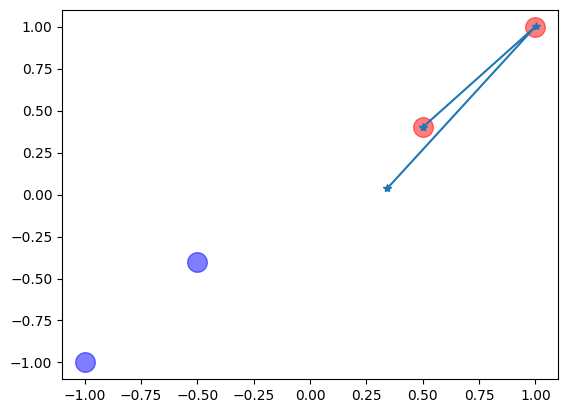

In [15]:
branch_path = th.rand((3, 2), requires_grad=True)
grad_tweak(branch_spec, branch_path, steps=1000, lr=1e-2)
branch_path_np = branch_path.detach().numpy()
plt.plot(branch_path_np[:, 0], branch_path_np[:, 1], "*-")
plt.scatter(branches[0, :, 0], branches[0, :, 1], s=200, color="r", alpha=0.5)
_ = plt.scatter(branches[1, :, 0], branches[1, :, 1], s=200, color="b", alpha=0.5)

Each branch is with different colors. The optimized trajectory visited the first branch (i.e., [1, 1], [0.5, 0.4]).

## Loop

The loop task asks a robot to loop among some waypoints. It can be written as
$$
    \square_{[1, T]}  \bigvee_{i=0}^{N-1} \left(\phi_i \land \bigcirc \phi_{(i+1)\%N} \right).
$$
This formula says that globally, any one of $\phi_i$ should be satisfied and $\phi_{(i+1)\%N}$ will be satisfied next time. % is the mod operator. The N-th term of this formula requires $\phi_0$ next. 

The above loop spec provides order. Alternatively, below is a loop spec without order
$$
    \square_{[1, T]} \left( \bigvee_{i=0}^N \phi_i \land \bigwedge_{i=0}^N \left(\phi_i \implies \lnot \bigcirc \phi_i \right) \right).
$$

In [9]:
loop_goals = np.array([
    [0, 0], [1, 1]
])
loop_spec = loop(loop_goals, close_radius=0.1)
loop_spec

G [1, None)((loop-wp-0 & X loop-wp-1) | (loop-wp-1 & X loop-wp-0))

initial score (< 0): -0.8078353404998779
final score (> 0): 0.01616045832633972


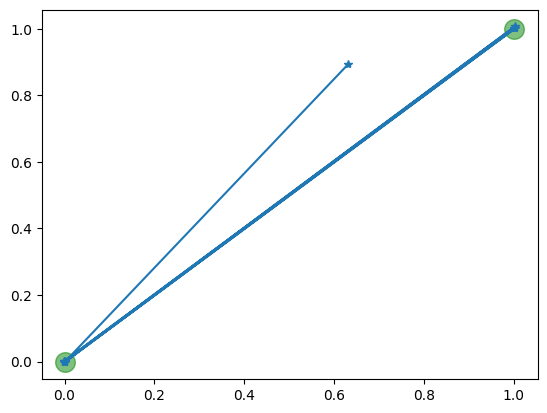

In [13]:
loop_path = th.rand((8, 2), requires_grad=True)
grad_tweak(loop_spec, loop_path, steps=2000, lr=1e-2)
loop_path_np = loop_path.detach().numpy()
plt.plot(loop_path_np[:, 0], loop_path_np[:, 1], "*-")
_ = plt.scatter(loop_goals[:, 0], loop_goals[:, 1], s=200, color="g", alpha=0.5)

The trajectory loops between [0, 0] and [1, 1]. 

## Signal

The signal task is a loop task with until operators:
$$
    \Diamond_{[1,T]} \phi_{N+1} \land \left(\square_{[1, T]} \bigvee_{i=0}^{N-1} \left(\phi_i \land \bigcirc \phi_{(i+1)\%N} \right) \right) \mathcal{U}_{[1,T]} \phi_{N}.
$$
This formula means that looping until $\phi_{N}$ is satisfied, and eventually visits the position specified by $\phi_{N+1}$.

In [11]:
signal_goals = np.array([
    [0, 0], [1, 1]
])
signal_final_goal = np.array([0, 1])
signal_spec = signal(signal_goals, signal_final_goal, until_time=6, close_radius=0.01)
signal_spec

traj[-1]<<[0 1]>> & (((loop-wp-0 & X loop-wp-1) | (loop-wp-1 & X loop-wp-0)) U [1, None)6s)

initial score (< 0): -0.943177342414856
final score (> 0): -0.07049958407878876


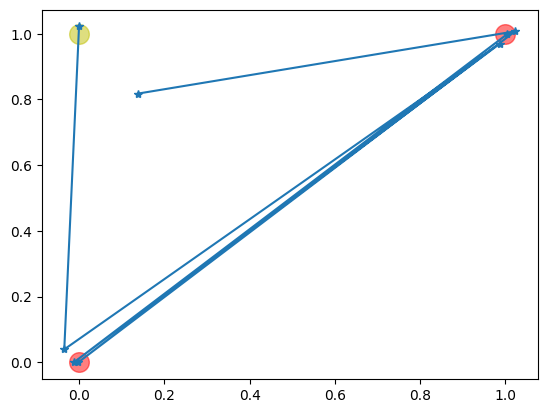

In [12]:
signal_path = th.rand((8, 2), requires_grad=True)
grad_tweak(signal_spec, signal_path, steps=1000)
signal_path_np = signal_path.detach().numpy()
plt.plot(signal_path_np[:, 0], signal_path_np[:, 1], "*-")
_ = plt.scatter(signal_goals[:, 0], signal_goals[:, 1], s=200, color="r", alpha=0.5)
_ = plt.scatter(signal_final_goal[0], signal_final_goal[1], s=200, color="y", alpha=0.5)

The trajectory visited the red goals 6 times and finally went to the yellow goal. 